# <center>Oil Viscosity</center>

The viscosity of an oil can factor into many calculations that are needed in the response of a spill, such as spreading and dispersion.

## <center>Importing and Estimating Initial Values</center>

In the PyGnome oil library, kinematic viscosity is primarily used, although the imported oil records sometimes do contain dynamic viscosity measurements.<br>
We would like to maintain as much of the useful imported information as we can.  So when we do encounter imported records with dynamic viscosities, we convert them to kinematic for use with the oil library.

The conversion from dynamic viscosity to kinematic viscosity is:

$$
\begin{align}
\eta0_{oil} &= \text{the dynamic viscosity of our oil in } Pa \cdot s \left( \text{aka } {kg \over m \cdot s} \right) \cr
\rho0_{oil} &= \text{the density of our oil in } kg/m^3 \cr
v0_{oil} &= {\eta0_{oil} \over \rho0_{oil} } = \text{the kinematic viscosity of our oil in } m^2 / s
\end{align}
$$

### <u>Some Examples</u>

Ok, let's apply this to some examples using records in our oil library.<br>
First we will import some things from our oil library that we will need.

In [1]:
import numpy as np
from scipy.optimize import curve_fit

from pylab import *

%matplotlib inline

from oil_library import get_oil, get_oil_props, _get_db_session
from oil_library.utilities.estimations import pour_point_from_kvis
from oil_library.models import (Base, ImportedRecord, Oil,
                                Density, KVis, DVis,
                                Toxicity, Category)
from oil_library.oil_props import OilProps

session = _get_db_session()

Now we can query for an oil that we are interested in.

#### Example 1:  Estimating Kinematic Viscosity

For this example, we will examine an oil that has no kinematic viscosities, but does in fact have a measured dynamic viscosity.

In [2]:
# query all imported records that have DVis but no KVis
recs = (session.query(ImportedRecord)
        .join(DVis)
        .outerjoin(KVis)
        .filter(KVis.imported_record_id == None)
        .all())
print len(recs)

# query all Oils associated with our imported records.
oils = [r.oil for r in recs if r.oil is not None]
print len(oils)

# now let's choose one that matches our example precisely
oil_obj = [o for o in oils
           if (len(o.imported.densities) == 0)][0]
print oil_obj
print oil_obj.imported.dvis
print oil_obj.imported.kvis

128
126
<Oil("KUWAIT EXPORT")>
[<DVis(0.0581 kg/ms at 310.9278K)>]
[]


The imported record for this oil contains a dynamic viscosity, but no kinematic viscosity.  So we will need to convert it to a kinematic viscosity using the method above.<br>
So in order to do that, we need to get the density for this oil.

In [3]:
print oil_obj.imported.densities
print oil_obj.imported.api

[]
31.4


Alright, you can see that the imported record for this oil also has no densities, but it does have an API.  So of course we will need to convert the API to a density at $ 15^\circ C $.<br>
Fortunately, the oil object already has this estimated.<br>
<i>(For details on this, please see the Oil density discussion )</i>

In [4]:
print oil_obj.densities

[<Density(868.631062001 kg/m^3 at 288.15K)>]


Now, is this the density value we want?  Not really, because we would really like to know what the oil density is at $ 310.93^\circ K $

For a full discussion of calculating the oil density at a temperature, please see the Oil Density notebook document.  But for our purposes, we will use the convenience function density_at_temp() located in the PyGnome oil_library module.

It takes a reference density, a reference temperature, and an optional expansion coefficient.

There is a default expansion coefficient of 0.0008 used by this utility function.  This is a reasonable average estimate, but in this case we want to verify that the oil's viscosity is close to what we would expect.  So we will also get the expansion coefficient that is used by the record.

In [5]:
from oil_library.utilities.estimations import density_at_temp
from oil_library.imported_record.estimations import ImportedRecordWithEstimation

# we need a good expansion coefficient from our imported record
imp_rec = ImportedRecordWithEstimation(oil_obj.imported)
expansion_coeff = imp_rec._vol_expansion_coeff(imp_rec.get_densities(), 310.9278)
print 'Expansion Coefficient: ', expansion_coeff

density_at_311k = density_at_temp(oil_obj.densities[0].kg_m_3,
                                  oil_obj.densities[0].ref_temp_k,
                                  310.9278,
                                  expansion_coeff)
print 'density at 311K: ', density_at_311k


Expansion Coefficient:  0.0009
density at 311K:  851.181817714


Alright, now we have the dynamic viscosity and the density.  Now we can calculate the kinematic viscosity at $ 310.93^\circ K $

In [6]:
dvis = oil_obj.imported.dvis[0]
dvis.kg_ms
kinematic_viscosity_at_311k = dvis.kg_ms / density_at_311k
print kinematic_viscosity_at_311k

6.82580369914e-05


Ok, let's see if that is what was estimated for our oil.

In [7]:
print oil_obj.kvis

[<KVis(6.82580369914e-05 m^2/s at 310.9278K)>]


Sure enough, the oil object has a kinematic value that matches our work.

#### Example 2:  Dynamic Viscosities must be at unique temperatures.

In [8]:
oil_obj = (session.query(Oil)
           .filter(Oil.name == 'DESTIN DOME CIS, MMS')
           .one())
print oil_obj
print oil_obj.imported.dvis
print oil_obj.imported.kvis

<Oil("DESTIN DOME CIS, MMS")>
[<DVis(0.00274 kg/ms at 313.15K)>]
[<KVis(3.16e-06 m^2/s at 313.15K)>]


This record has both a dynamic and kinematic density at $ 313^\circ K $. 

If an oil record has both a kinematic and dynamic viscosity at a particular temperature, we will prefer the kinematic.  

In [9]:
print oil_obj.kvis

[<KVis(3.16e-06 m^2/s at 313.15K)>]


However any dynamic viscosities that exist at unique temperatures will be converted to kinematic and used.

In [10]:
oil_obj = (session.query(Oil)
           .filter(Oil.name == 'ROSSIIELF, RUSSIAN JOINT STOCK CO')
           .one())
print oil_obj
print oil_obj.imported.dvis
print oil_obj.imported.kvis

<Oil("ROSSIIELF, RUSSIAN JOINT STOCK CO")>
[<DVis(0.12 kg/ms at 273.15K)>]
[<KVis(1.957e-05 m^2/s at 313.15K)>, <KVis(1.395e-05 m^2/s at 323.15K)>]


This oil has a couple of kinematic viscosities, but also has a dynamic viscosity at a temperature that does not match any of the kinematic viscosities.<br>
Here we will convert the dynamic viscosity and add it to the list of kinematic viscosities.

In [11]:
print oil_obj.kvis

[<KVis(0.000129914529915 m^2/s at 273.15K)>, <KVis(1.957e-05 m^2/s at 313.15K)>, <KVis(1.395e-05 m^2/s at 323.15K)>]


<hr style="height:3px">

## <center>Finding Oil Viscosity at Temperature</center>

So now that we have initial measured viscosities and their respective reference temperatures, we will need to estimate the oil's viscosity at a certain temperature or temperatures in order to provide reasonable viscosity values for a PyGnome model.

Estimating Viscosity at a certain temperature is done using the following formula:

$$
\begin{align}
v_{ref} &= \text{A measured reference viscosity} \cr
T_{ref} &= \text{The temperature at which the reference viscosity was measured} \cr
T_{pp} &= \text{The pour point (the point at which the substance stops behaving like a fluid)} \cr
T &= \text{The temperature at which we would like to compute the viscosity} \cr
k_{v2} &= \text{The Viscosity Temperature Parameter} \cr
\cr
v_{max} &= v_{ref} exp \left( k_{v2} \cdot \left[ \frac 1{T_{pp}} - \frac 1{T_{ref}} \right] \right) \cr
v_0 &= \left[ v_{ref} exp \left( k_{v2} \cdot \left[ \frac 1T - \frac 1{T_{ref}} \right] \right) \right]^{\bot v_{max}}_{ \top 0} \cr
\end{align}
$$

Alright, most of the parameters above are self-explanatory, and coming up with reasonable values for them is fairly straightforward.<br>
But what is a reasonable value for $ k_{v2} $?

Well, Payne et al (1982) recommend that $ k_{v2} = 9000^\circ K $.  But Adios 2, based on the results of several oil measurements recorded in the Environment Canada database, instead uses $ k_{v2} = 5000^\circ K $.

In [12]:
def kvis_at_temp(ref_kvis, ref_temp_k, temp_k):
    k_v2 = 5000.0

    return ref_kvis * np.exp(k_v2 / temp_k - k_v2 / ref_temp_k)


The formula above has been packaged as a function in the oil library.  Here is its import location

In [13]:
from oil_library.utilities.estimations import kvis_at_temp

In addition, it has been packaged as a method of oil objects.

### <u>Some Examples</u>

Here we will get an oil with a number of measured kinematic viscosities and make a graph of the interpolated viscosities as a function of temperature.

Alright, first let's get our oil.

In [14]:
oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02448').one()
print oil_obj

<Oil("LUCKENBACH FUEL OIL")>


Ok, now we need to determine a good temperature range that we can use to graph our viscosities.

In [15]:
oil_obj.kvis

[<KVis(0.245 m^2/s at 288.7056K)>,
 <KVis(0.0641 m^2/s at 294.2611K)>,
 <KVis(0.0225 m^2/s at 299.8167K)>,
 <KVis(0.00458 m^2/s at 310.9278K)>]

In [16]:
pour_point_from_kvis(oil_obj.kvis[0].m_2_s,
                     oil_obj.kvis[0].ref_temp_k)

267.02016700827045

It seems that a range from $ 250^\cdot K - 350^\cdot K $ will work.

(25.00494, 294.2611)
(14.40662, 310.9278)


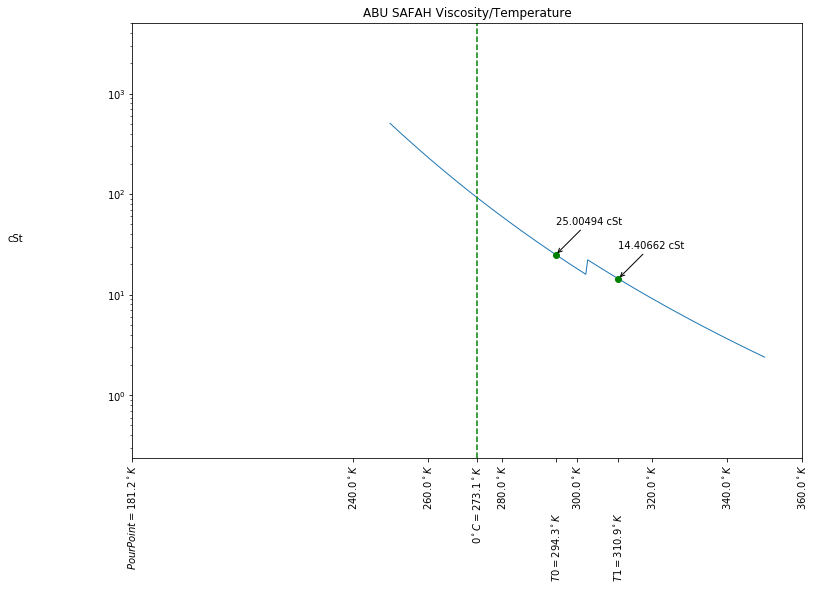

In [17]:
plt.figure(1, figsize=(12,8))
ax = plt.subplot(111)

#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02448').one()
#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD04009').one()
oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD00009').one()
imp_rec = ImportedRecordWithEstimation(oil_obj.imported)

temps = np.linspace(250.0, 350.0, 200)
kvis_ref_temps = [v.ref_temp_k for v in oil_obj.kvis]
kvis_refs = [v.m_2_s * 1e6 for v in oil_obj.kvis]
for v, t in zip(kvis_refs, kvis_ref_temps):
    print (v, t)

pour_point = pour_point_from_kvis(oil_obj.kvis[0].m_2_s,
                                  oil_obj.kvis[0].ref_temp_k)

x = temps
y = imp_rec.kvis_at_temp(temps) * 1e6

graph_max = np.max(y) * 10
graph_min = np.min(y) / 10

plot(x, y, linewidth=1)
axis([np.min(temps), np.max(temps), graph_min, graph_max])
ax.axvline(273.15, color='g', ls='--')
ax.axhline(0, color='g', ls='--')

ax.set_title('{0} Viscosity/Temperature'.format(oil_obj.name))
figtext(-0.02, 0.5, 'cSt')

# annotations
for v, t in zip(kvis_refs, kvis_ref_temps):
    ax.plot(t, v, marker='o', color="green")
    ax.annotate('{0} cSt'.format(v),
                xy=(t, v),  xycoords='data',
                xytext=(0, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )

# generate x ticks
kvis_ref_ticks = [(v, r'$T{0}={1:.1f}^\circ K$                '.format(i, v))
                  for i, v in enumerate(kvis_ref_temps)]
x_ticks = [(v, r'${0:.1f}^\circ K$'.format(v)) for v, l in zip(*plt.xticks())]
x_ticks += kvis_ref_ticks
x_ticks += [(273.15, r'$0^\circ C={0:.1f}^\circ K$'.format(273.15))]
x_ticks += [(pour_point, r'$PourPoint = {0:.1f}^\circ K$'.format(pour_point))]
plt.xticks(*zip(*x_ticks))
plt.yscale('log', nonposy='clip')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small')
    tick.label.set_rotation('vertical')

show()

It seems visually intuitive from looking at the above graph that the rate at which the kinematic viscosity decreases with temperature, a rate that is calculated using the above formula, does not in fact match our data points.  It seems that we may need to implement something that will adjust the rate somehow.

First we parameterize $k_{v2}$ for the kvis-to-temperature formula

In [18]:
def kvis_at_temp(temp_k, ref_kvis, ref_temp_k, k_v2):
    return ref_kvis * np.exp(k_v2 / temp_k - k_v2 / ref_temp_k)

We need a form of the function that we can use to perform a curve optimization to determine $k_{v2}$.
We can derive this form by compartmentalizing parts of the equation that are not affected by a change in temperature.
This derivation is as follows:

$$
\begin{align}
v_0 &= v_{ref} exp \left( \frac {k_{v2}} T - \frac {k_{v2}} {T_{ref}} \right) \cr
v_0 &= \left( v_{ref} \cdot e^{-k_{v2} / T_{ref}} \right) \cdot e^{k_{v2} / T} \cr
v_0 &= a \cdot exp \left( \frac {k_{v2}} T \right) \cr
\end{align}
$$

Here we are interested not so much in the coefficient $a$, but the exponential coefficient $k_{v2}$

(2.5004940000000001e-05, 294.2611, 0.0)
(1.440662e-05, 310.92779999999999, 0.0)
trying (k_v2, a) =  (1995.2623149688789, 2.8395877489823502e-08)
	popt:  [  8.52470134e-10   3.02690085e+03]
	pcov:  [[ inf  inf]
 [ inf  inf]]
	k_v2 deviation:  inf
using popt:  [  8.52470134e-10   3.02690085e+03]


/Users/james.makela/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


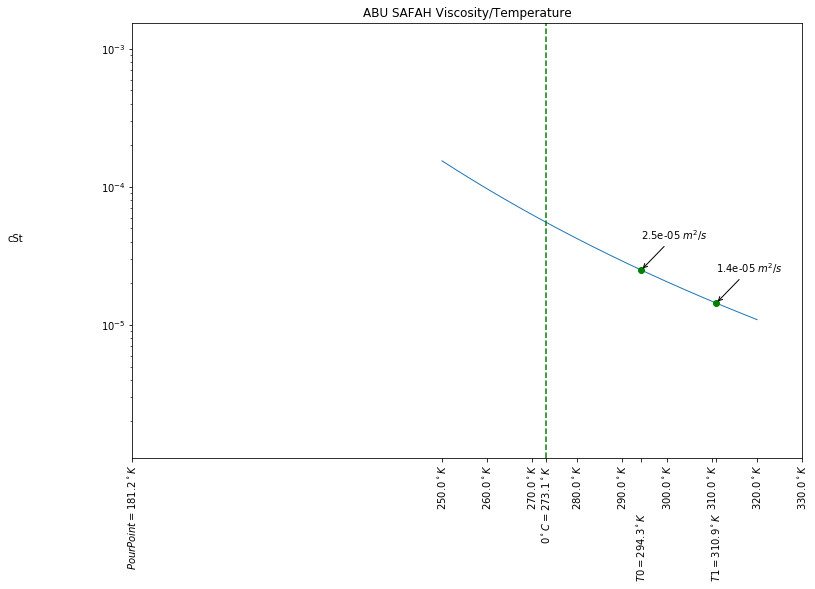

In [19]:
plt.figure(1, figsize=(12,8))
ax = plt.subplot(111)

# This oil has an exponential increase with temperature.  Why??
#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD00311').one()

# These oils show a flat viscosity response to temperature.  Why??
#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02548').one()
#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02552').one()

#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02448').one()
#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD04009').one()
oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD00009').one()

temps = np.linspace(250.0, 320.0, 200)
kvis_ref_temps = np.array([v.ref_temp_k for v in oil_obj.kvis])
kvis_refs = np.array([v.m_2_s for v in oil_obj.kvis])
kvis_weathering = np.array([v.weathering for v in oil_obj.kvis])
pour_point = pour_point_from_kvis(oil_obj.kvis[0].m_2_s,
                                  oil_obj.kvis[0].ref_temp_k)

for v, t, w in zip(kvis_refs, kvis_ref_temps, kvis_weathering):
    print (v, t, w)

# This works pretty well for IFO 180
# - initial a = 0.01
# - initial k_v2 = 6000
def exp_func(temp_k, a, k_v2):
    return a * np.exp(k_v2 / temp_k)

for k in np.logspace(3.3, 4.5, num=8):
    # log range from about 5000-32000
    a_coeff = kvis_refs[0] * np.exp(-k / kvis_ref_temps[0])
    try:
        print 'trying (k_v2, a) = ', (k, a_coeff)
        popt, pcov = curve_fit(exp_func, kvis_ref_temps, kvis_refs,
                               p0=(a_coeff, k), maxfev = 2000)
        
        std_dev = np.sqrt(np.diag(pcov))
        print '\tpopt: ', popt
        print '\tpcov: ', pcov
        print '\tk_v2 deviation: ', (std_dev/popt)[1]

        # - we want our covariance to be a reasonably small number,
        #   but it can get into the thousands even for a good fit.
        #   So we will only check for inf values.
        # - for sample sizes < 3, the covariance is unreliable.
        if len(kvis_refs) > 2 and np.any(pcov == np.inf):
            print '\tcovariance too high: {}', pcov
            continue

        break
    except (ValueError, RuntimeError), e:
        print '\tcaught exception: ', e
        continue

print 'using popt: ', popt
x = temps
y = exp_func(temps, *popt)

graph_max = np.max(y) * 10
graph_min = np.min(y) / 10

plot(x, y, linewidth=1)
axis([np.min(temps), np.max(temps) + 10.0, graph_min, graph_max])
ax.axvline(273.15, color='g', ls='--')
ax.axhline(0, color='g', ls='--')

ax.set_title('{0} Viscosity/Temperature'.format(oil_obj.name))
figtext(-0.02, 0.5, 'cSt')

# annotations
for v, t in zip(kvis_refs, kvis_ref_temps):
    ax.plot(t, v, marker='o', color="green")
    ax.annotate(r'{0:.2g} $m^2/s$'.format(v),
                xy=(t, v),  xycoords='data',
                xytext=(0, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )

# generate x ticks
kvis_ref_ticks = [(v, r'$T{0}={1:.1f}^\circ K$                '.format(i, v))
                  for i, v in enumerate(kvis_ref_temps)]
x_ticks = [(v, r'${0:.1f}^\circ K$'.format(v)) for v, l in zip(*plt.xticks())]
x_ticks += kvis_ref_ticks
x_ticks += [(273.15, r'$0^\circ C={0:.1f}^\circ K$'.format(273.15))]
x_ticks += [(pour_point, r'$PourPoint = {0:.1f}^\circ K$'.format(pour_point))]
plt.xticks(*zip(*x_ticks))
plt.yscale('log', nonposy='clip')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small')
    tick.label.set_rotation('vertical')

show()

Ok, this curve optimization fits the data reasonably for a couple of different oils.  We now turn this process into a more easily usable function.


In [20]:
def determine_k_v2(ref_temp_k, ref_kvis):
    k_v2 = 5000.0  # default if we can't find an optimization

    def exp_func(temp_k, a, k_v2):
        return a * np.exp(k_v2 / temp_k)

    for k in np.logspace(3.6, 4.5, num=8):
        # k = log range from about 5000-32000
        a_coeff = ref_kvis[0] * np.exp(-k / ref_temp_k[0])

        try:
            popt, pcov = curve_fit(exp_func, ref_temp_k, ref_kvis,
                                   p0=(a_coeff, k), maxfev = 2000)

            # - we want our covariance to be a reasonably small number,
            #   but it can get into the thousands even for a good fit.
            #   So we will only check for inf values.
            # - for sample sizes < 3, the covariance is unreliable.
            if len(ref_kvis) > 2 and np.any(pcov == np.inf):
                print 'covariance too high.'
                continue

            k_v2 = popt[1]
            #std_dev = np.sqrt(np.diag(pcov))
            break
        except (ValueError, RuntimeError), e:
            print 'caught exception: ', e
            continue

    return k_v2


Now let's see what the $k_{v2}$ trends are for the oils in our database.

In [21]:
k_v2_list = []
for oil_obj in session.query(Oil).filter(Oil.product_type == 'Crude'):
    if len(oil_obj.imported.kvis) >= 2:
        k_v2 = determine_k_v2(*zip(*[(k.ref_temp_k, k.m_2_s)
                                     for k in oil_obj.imported.kvis]))
        k_v2_list.append(k_v2)
        if k_v2 < 0.0:
            print (oil_obj.name, oil_obj.adios_oil_id), k_v2

print np.min(k_v2_list), np.max(k_v2_list), np.mean(k_v2_list)


caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
(u'DUBAI, CITGO', u'AD00311') -1970.84061009
caught exception:  Optimal parameters not found: Number of calls to function has reached maxfev = 2000.
caught exception:  

It is interesting to note that there are a few oils that have viscosity data resulting in a negative value for $k_{v2}$.  These are probably data errors, but we should protect ourselves from this possibility.  In this case, I suppose we could choose a default mean value.  And the default mean value we have been using is 5000.0.

In [22]:
def determine_k_v2(ref_temp_k, ref_kvis):
    k_v2 = 5000.0  # default if we can't find an optimization

    def exp_func(temp_k, a, k_v2):
        return a * np.exp(k_v2 / temp_k)

    for k in np.logspace(3.6, 4.5, num=8):
        # k = log range from about 5000-32000
        a_coeff = kvis_refs[0] * np.exp(-k / kvis_ref_temps[0])

        try:
            popt, pcov = curve_fit(exp_func, ref_temp_k, ref_kvis,
                                   p0=(a_coeff, k), maxfev = 2000)

            # - we want our covariance to be a reasonably small number,
            #   but it can get into the thousands even for a good fit.
            #   So we will only check for inf values.
            # - for sample sizes < 3, the covariance is unreliable.
            if len(ref_kvis) > 2 and np.any(pcov == np.inf):
                print 'covariance too high.'
                continue

            if popt[1] <= 1.0:
                continue
            
            k_v2 = popt[1]
            #std_dev = np.sqrt(np.diag(pcov))
            break
        except (ValueError, RuntimeError):
            continue

    return k_v2


/Users/james.makela/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


# Oils Total: 777, # Oils with multi-kvis: 250


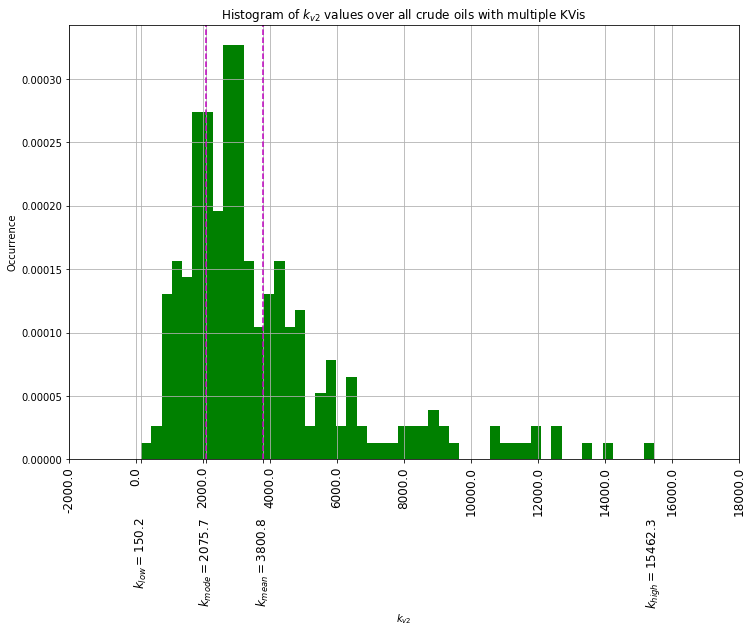

In [55]:
plt.figure(1, figsize=(12,8))
ax = plt.subplot(111)

k_v2_list = []
oils_total = 0
for oil_obj in session.query(Oil).filter(Oil.product_type == 'Crude'):
    oils_total += 1
    if len(oil_obj.imported.kvis) >= 2:
        k_v2 = determine_k_v2(*zip(*[(k.ref_temp_k, k.m_2_s)
                                     for k in oil_obj.imported.kvis]))
        k_v2_list.append(k_v2)
        if k_v2 < 0.0:
            print (oil_obj.name, oil_obj.adios_oil_id), k_v2
print '# Oils Total: {}, # Oils with multi-kvis: {}'.format(oils_total, len(k_v2_list))


k_low, k_high, k_mean = np.min(k_v2_list), np.max(k_v2_list), np.mean(k_v2_list)
k_std, k_var = np.std(k_v2_list), np.var(k_v2_list)

mu = np.log(k_mean / np.sqrt(1 + k_var / k_mean ** 2.0))
sigma = np.sqrt(np.log(1 + k_var / k_mean ** 2.0))
log_mode = np.exp(mu - sigma ** 2.0)

# the histogram of the data
n, bins, patches = ax.hist(k_v2_list, 50, normed=1, facecolor='green')

ax.set_xlabel('$k_{v2}$')
ax.set_ylabel('Occurrence')
ax.set_title(r'Histogram of $k_{v2}$ values over all crude oils with multiple KVis')

ax.axvline(k_mean, color='m', ls='--')
ax.axvline(log_mode, color='m', ls='--')

x_ticks = [(v, v) for v, l in zip(*plt.xticks())]
x_ticks += [(k_mean, r'$k_{{mean}}={0:.1f}$              '.format(k_mean))]
x_ticks += [(log_mode, r'$k_{{mode}}={0:.1f}$              '.format(log_mode))]
x_ticks += [(k_low, r'$k_{{low}}={0:.1f}$              '.format(k_low))]
x_ticks += [(k_high, r'$k_{{high}}={0:.1f}$              '.format(k_high))]
plt.xticks(*zip(*x_ticks))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small')
    tick.label.set_rotation('vertical')

ax.grid(True)

show()

Plotting a histogram of the values of $k_{v2}$ for the crude oils, it does seem to indicate a lognormal distribution.  And we see that the distribution lognormal mode (2075.7) is a bit lower than the default we have been using (5000.0).  Bill's most recent document on viscosity as a function of temperature suggests an alternative value of 2416.0 (Abu-Eishah, 1999), which would seem to be a better default value to use based on the measured values in our set.

The majority of the crude oils in our database have only one viscosity measurement (527 total), and for these we don't have enough data to estimate $k_{v2}$.  So we will need to rely on a good default value most of the time.

However there seems to be a very wide range between the minimum and maximum values for the oils that we are able to estimate.  And it stands to reason that there is probably a similar stratification of viscosity properties for the oils that we are not able to estimate.  Of course using a default average $k_{v2}$ for those oils would not be appropriate, but we can not really know since we don't have the data.

Let's also try this for refined products.

/Users/james.makela/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


# Oils Total: 70, # Oils with multi-kvis: 7


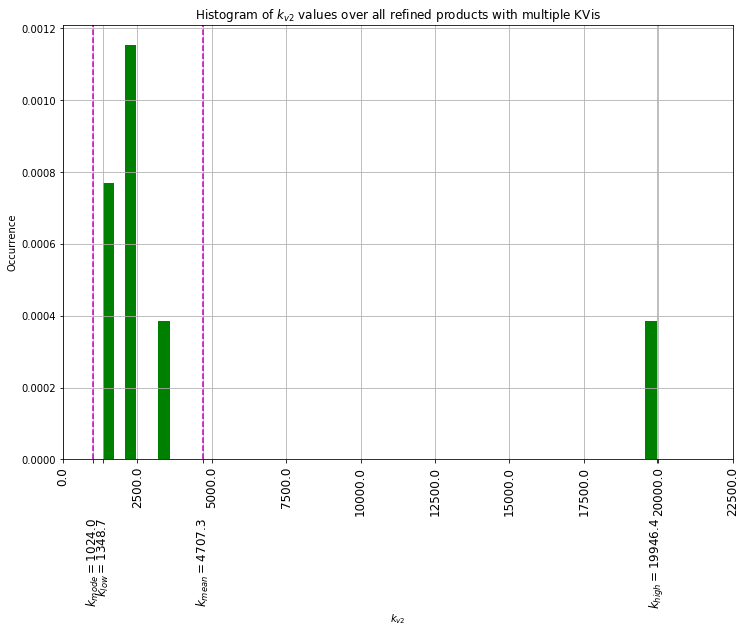

In [58]:
plt.figure(1, figsize=(12,8))
ax = plt.subplot(111)

k_v2_list = []
oils_total = 0
for oil_obj in session.query(Oil).filter(Oil.product_type == 'Refined'):
    oils_total += 1
    if len(oil_obj.imported.kvis) >= 2:
        k_v2 = determine_k_v2(*zip(*[(k.ref_temp_k, k.m_2_s)
                                     for k in oil_obj.imported.kvis]))
        k_v2_list.append(k_v2)
        if k_v2 < 0.0:
            print (oil_obj.name, oil_obj.adios_oil_id), k_v2
print '# Oils Total: {}, # Oils with multi-kvis: {}'.format(oils_total, len(k_v2_list))

k_low, k_high, k_mean = np.min(k_v2_list), np.max(k_v2_list), np.mean(k_v2_list)
k_std, k_var = np.std(k_v2_list), np.var(k_v2_list)

mu = np.log(k_mean / np.sqrt(1 + k_var / k_mean ** 2.0))
sigma = np.sqrt(np.log(1 + k_var / k_mean ** 2.0))
log_mode = np.exp(mu - sigma ** 2.0)

# the histogram of the data
n, bins, patches = ax.hist(k_v2_list, 50, normed=1, facecolor='green')

ax.set_xlabel('$k_{v2}$')
ax.set_ylabel('Occurrence')
ax.set_title(r'Histogram of $k_{v2}$ values over all refined products with multiple KVis')

ax.axvline(k_mean, color='m', ls='--')
ax.axvline(log_mode, color='m', ls='--')

x_ticks = [(v, v) for v, l in zip(*plt.xticks())]
x_ticks += [(k_mean, r'$k_{{mean}}={0:.1f}$              '.format(k_mean))]
x_ticks += [(log_mode, r'$k_{{mode}}={0:.1f}$              '.format(log_mode))]
x_ticks += [(k_low, r'$k_{{low}}={0:.1f}$              '.format(k_low))]
x_ticks += [(k_high, r'$k_{{high}}={0:.1f}$              '.format(k_high))]
plt.xticks(*zip(*x_ticks))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small')
    tick.label.set_rotation('vertical')

ax.grid(True)

show()

Here we see that the histogram does sort of begin to approximate a lognormal.  But the number of samples is so small that I don't think we can really have confidence in the calculated mean and mode values.  With a larger sample size, we might start to see something that we can draw some conclusions from.

It is currently not a requirement that a refined product have multiple viscosities.  And a quick query shows that only 7 out of 70 refined products have them.  It would be nice if we had more viscosity data for these records.

Visually, and based on the above, I believe that if we needed to choose a default, it would lie somewhere around 2500.0.  So again, Abu-Eishah's (1999) alternative recommendation of 2416.0 would probably work.
